# SARIMA модель для прогнозирования временного ряда

**Disclamer:**
результаты этого метода не говорят о том, хороший это метод или плохой. Они лишь говорят о том, подходит этот метод к конкретно используемым входным данным или нет

In [1]:
import pandas as pd
import numpy as np

# для разбиения на тестовую и тренировочную выборки
from sklearn.model_selection import train_test_split

# библиотеку для графиков
import matplotlib.pyplot as plt

# метрики моделей регрессии
from sklearn.metrics import mean_squared_error , mean_absolute_error # mse , mae

# модель линейной регрессии
from sklearn.linear_model import LinearRegression

# градиентный бустинг с кросс-валидацией в библиотеке catboost
from catboost import CatBoostRegressor, Pool, cv

from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

# для выгрузки моделей
import joblib




import statsmodels.api as sm

Выгрузим и обработаем данные.
Наши данные представляют из себя количество операций продажи по определенному сценарию.  

In [2]:
sales = pd.read_csv('data_3.csv', index_col=[0])
display(sales.head(5))
sales.info()

,магазин,день,кол-во
0,магазин 3,2019-01-02,1
1,магазин 2,2019-01-02,3
2,магазин 1,2019-01-02,48
3,магазин 3,2019-01-03,3
4,магазин 1,2019-01-03,87


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2605
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   магазин  2606 non-null   object
 1   день     2606 non-null   object
 2   кол-во   2606 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 81.4+ KB


Выгрузили и посмотрели типы. Сразу приведем столбец день к дате. И проверим, все ли даты у нас есть в наличие.

In [3]:
sales['день'] = pd.to_datetime(sales['день'], format='%Y-%m-%d')

display(sales.pivot_table(index='день', values='кол-во', columns = 'магазин'))

print(sales.pivot_table(index='день', values='кол-во', columns = 'магазин').isna().sum())


магазин,магазин 1,магазин 2,магазин 3
день,,,
2019-01-02,48.0,3.0,1.0
2019-01-03,87.0,NaN,3.0
2019-01-04,68.0,1.0,4.0
2019-01-05,75.0,9.0,6.0
2019-01-06,70.0,1.0,5.0
...,...,...,...
2021-05-27,77.0,20.0,5.0
2021-05-28,67.0,26.0,10.0
2021-05-29,70.0,18.0,12.0


магазин
магазин 1     0
магазин 2    17
магазин 3    14
dtype: int64


Отлично. мы знаем, что не для всех магазинов у нас есть данные по каждому месяцу. Исправим это недоразумение. Отсутствие данных = отсутствию продаж, поэтому будем менять на ноль. 

In [4]:
sales = sales.pivot_table(index='день', values='кол-во', columns = 'магазин', fill_value=0)

Кроме того, мы точно знаем, что, например 1 января 2020 года ни один магазин не работал, поэтому дата "2020-01-01" будет отсутствовать, а это плохо. Поэтому ресемплируем данные по дням и заполним пропуски тоже нулями

In [5]:
sales = sales.resample('D').asfreq().fillna(0)

display(sales)
print(sales.isna().sum())





магазин,магазин 1,магазин 2,магазин 3
день,,,
2019-01-02,48.0,3.0,1.0
2019-01-03,87.0,0.0,3.0
2019-01-04,68.0,1.0,4.0
2019-01-05,75.0,9.0,6.0
2019-01-06,70.0,1.0,5.0
...,...,...,...
2021-05-27,77.0,20.0,5.0
2021-05-28,67.0,26.0,10.0
2021-05-29,70.0,18.0,12.0


магазин
магазин 1    0
магазин 2    0
магазин 3    0
dtype: int64


Отлично. Теперь наш времянной ряд приведен в нормальное состояние. И бонусом мы узнали, что не только "2020-01-01" магазины были закрыты, но и еще в какой-то день (размер таблицы вырос с 879 строк до 881 строки). Отсутствовали продажи 1 января 2021г и изначально мы специально умолчали об этом, чтобы проверить правильно ли все отработает.

Посмотрим на графики количества продаж для каждого магазина

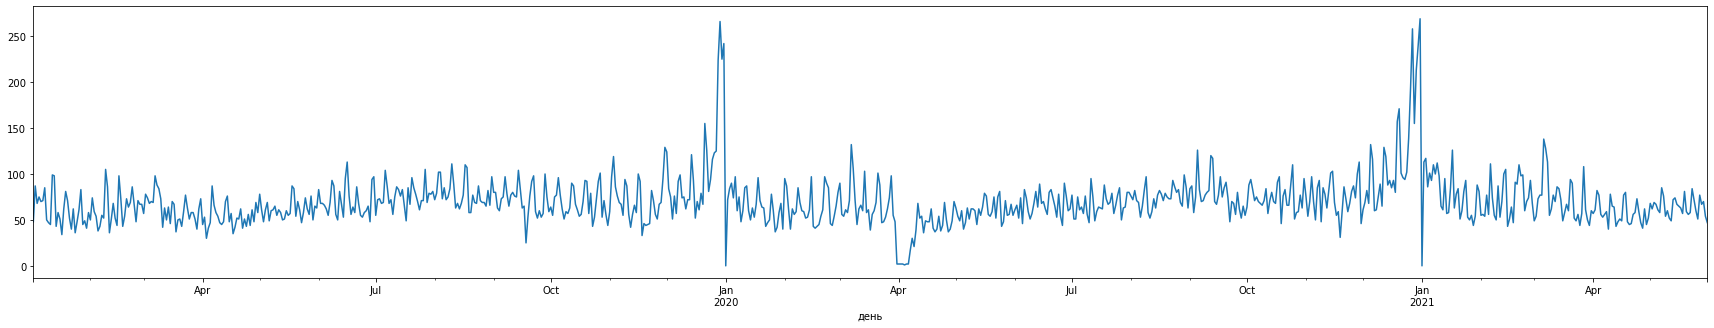

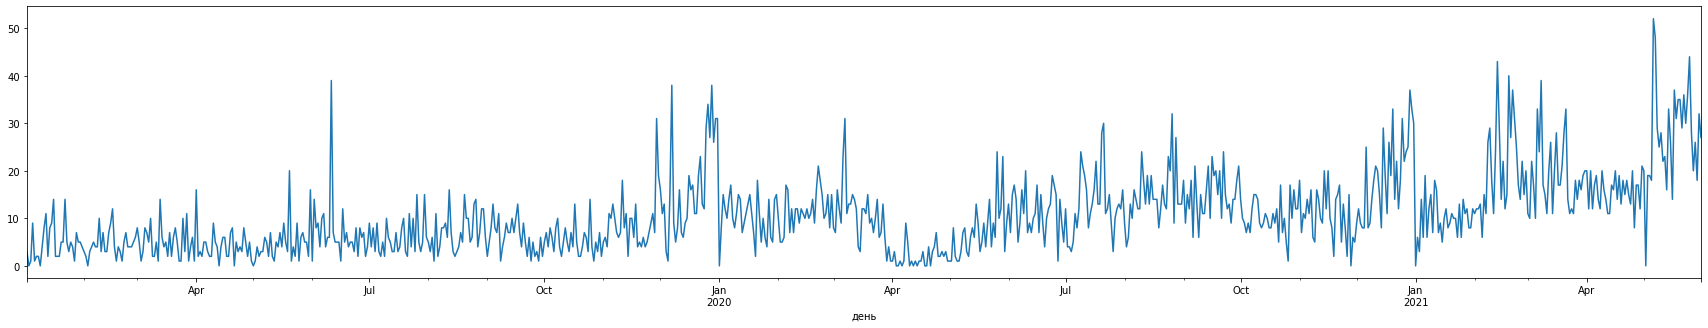

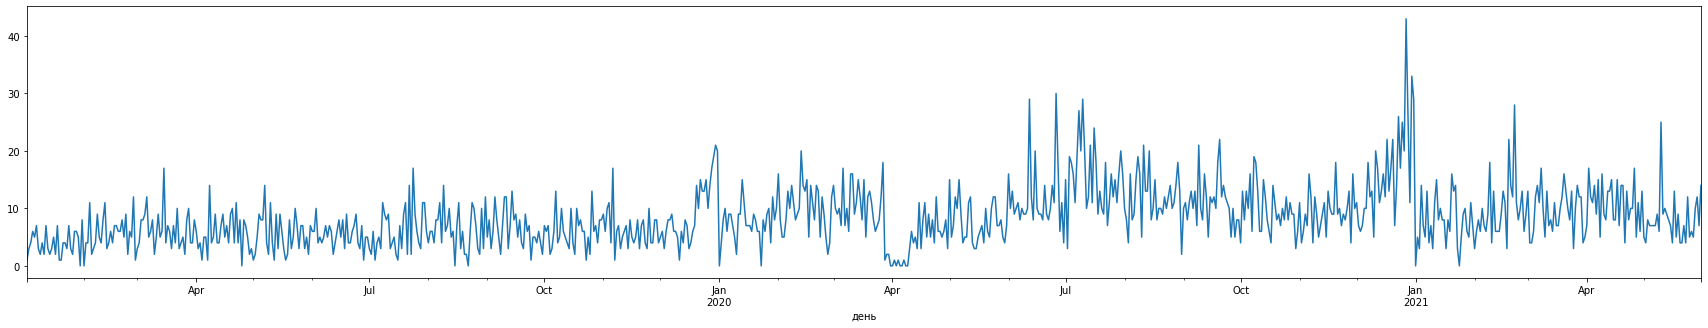

In [6]:
for col in sales.columns:
    sales[col].plot(figsize = (30,5))
    plt.show()

# SARIMA модель для 1 магазина.

Возьмем данные по 1 магазину и попробуем спрогнозировать количество продаж на будущий месяц. 

Для примера возьмем "магазин 2", потому он выглядит как менее стационарный относительно "магазина 1" и, в отличие от "магазина 3" в конце периода данных явно имеет изменение объемов продаж.



In [7]:
one = sales['магазин 2']

Мы знаем, что последний доступный месяц наблюдений - май 2021 года, в полном объеме. Его и возьмем в качестве данных на которых будем валидировать модель. Остальные данные используем для обучения.

In [8]:
one_valid = one[-31:]
one_train = one[:-31]

Посмотрим на тренд, сезонность и шумы для нашего тренировочного ряда.

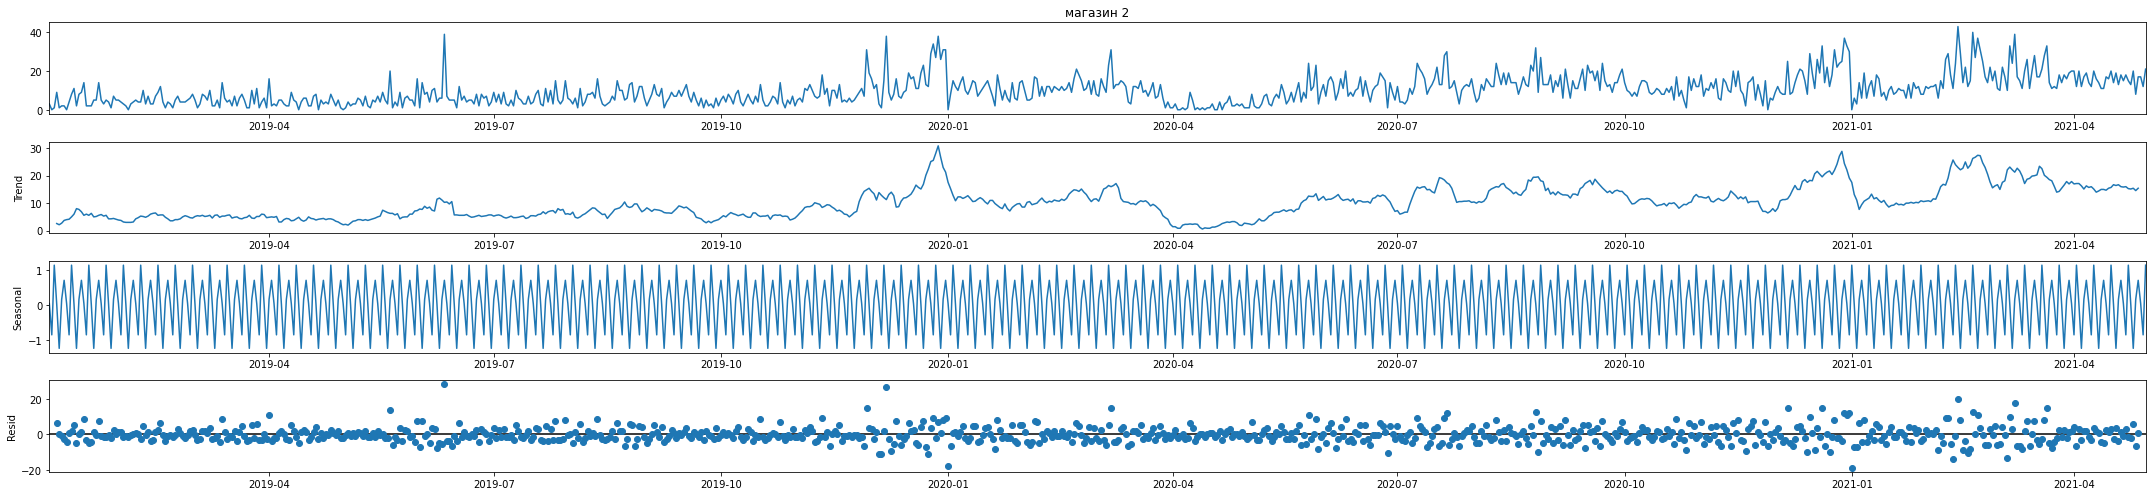

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 30, 7

decomposition = sm.tsa.seasonal_decompose(one_train, model='additive')

fig = decomposition.plot()
plt.show()

Отлично. В наших данных есть внутригодовая и внутринедельная сезонность, долгосрочный восходящий тренд и увеличение дисперсии шумов со временем. Полный набор...


Стандартная Arima модель нам не подходит, потому как у нас есть сезонная компонента, а значит будем использовать SARIMA модель


Сформируем параметры SARIMA (p,d,q)(P,D,Q)m:
- p порядок авторегрессионного тренда (как и в ARIMA)
- d порядок изменения тренда (как и в ARIMA)
- q тренд скользящей средне (как и в ARIMA)

- P сезонный порядок авторегрессии
- D порядок сезонных разниц
- Q сезонный порядок скользящих средних
- m количество сезонных шагов за 1 сезонный период

В нашем подходе будем пологаться на годовой цикл сезонности, т.е m=12

In [10]:
import itertools

p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)


Для оценки качества различных моделей, которые построенны на различных наборах (p,d,q)(P,D,Q)m будем использовать информационный критерий Акайке, который показывает относительное качество стат.моделей для заданного набора данных (т.е. для каждого набора параметров происходит оценка результатов модели относительно результатов модели на всех остальных наборах параметров). Чем ниже значение этого критерия - тем лучше.

Для построения модели будем использовать функцию SARIMAX из пакета statmodels. Эта имплементация SARIMA алгоритма, где Х означает, что мы можем добавить экзогенные факторы, но у нас их нет, а без добавления это превращается в модель SARIMA.

In [11]:
list_param = []
list_param_seasonal = []
list_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results_12 = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(param,param_seasonal, results_12.aic))
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_aic.append(results_12.aic)
        except: 
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:6688.664939282296
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:6209.683101753797
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:5877.427127673027
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:5466.848963574501
SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:5800.589176125863
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:5513.95810322189
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:5628.759319729672
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:5468.717052102071
SARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:6194.843082568515
SARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:5939.8411432218145
SARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:5832.98805343036
SARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:5362.807373603735
SARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:5729.215299312962
SARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:5411.767592721947
SARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:5565.071919259769
SARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:5364.770253937109
SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:5671.335915180241
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:5596.359715387007
SARIMA(0, 1, 0)x(0, 1, 0, 12)

C:\Users\Baturin.GG\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:5258.229900571952
SARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:5495.74250573656
SARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:5217.781291825189
SARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:5490.406281418173
SARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:5418.673073599363
SARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:6036.257621174338
SARIMA(1, 1, 0)x(0, 1, 1, 12) - AIC:5384.663264037267
SARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:5418.416494974084
SARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:5419.902338022629
SARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:5687.681473484353
SARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:5386.633954423998
SARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:5311.086475351999
SARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:5242.606177573789
SARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:5824.956534171801
SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:5212.077657349844
SARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:5248.412134310824
SARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:5243.877946763614
SARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:5518.622464813641
SARIMA(1, 1, 1)x(1, 1, 1, 12)

Поскольку мы сохранили все параметры и значение критея в списки, то мы можем теперь найти минимальное значение критерия и значения лучших параметров (p, d, q) и (P,D,Q)

In [12]:
# найдем индекс минимального значения критерия aic
best_aic, idx_of_best_aic = min((val, idx) for (idx, val) in enumerate(list_aic))

# найдем (p,d,q) при которых достигается минимальное значение aic
best_param = list_param[idx_of_best_aic]

# найдем (P,D,Q) при которых достигается минимальное значение aic
best_param_seasonal = list_param_seasonal[idx_of_best_aic]


Когда знаем лучшие праметры модели - самое время обучить модель на тренировочных данных

In [13]:
mod = sm.tsa.statespace.SARIMAX(one_train,
                                order=(best_param[0], best_param[1], best_param[2]),
                                seasonal_order=(best_param_seasonal[0], best_param_seasonal[1], best_param_seasonal[2], best_param_seasonal[3]),
                                enforce_stationarity=True,
                                enforce_invertibility=True
                                )
results_12 = mod.fit()

#print(results_12.summary().tables[1])

Есдт нам интересно посмотреть на стандартизированиие остатки, диаграмм плотности распределения и коррелограмму то можно это сделать:

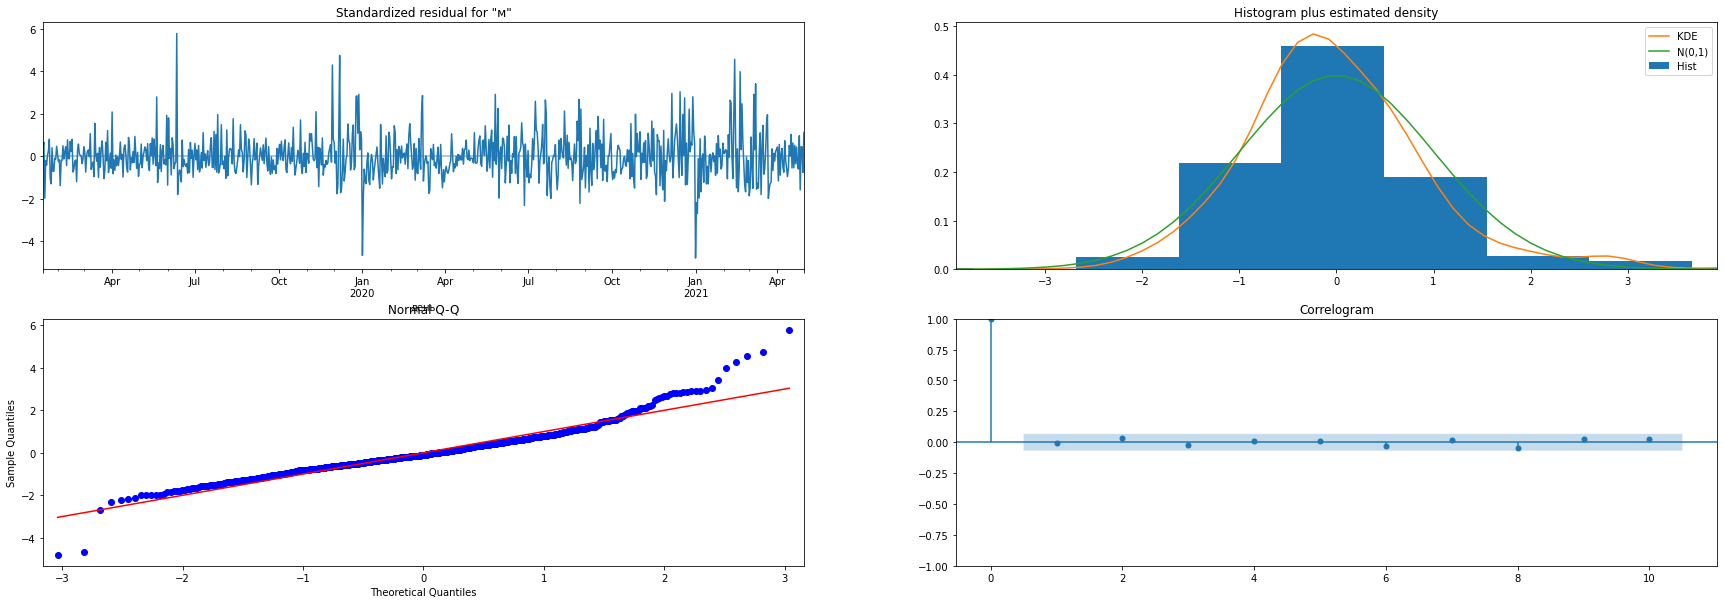

In [14]:
results_12.plot_diagnostics(figsize=(30, 10))
plt.show()

Сделаем некоторый аналог кросс-валидации и попытаемся предсказать продажи для последнего месяца наших тренировочных данных и посмотрим на результат.

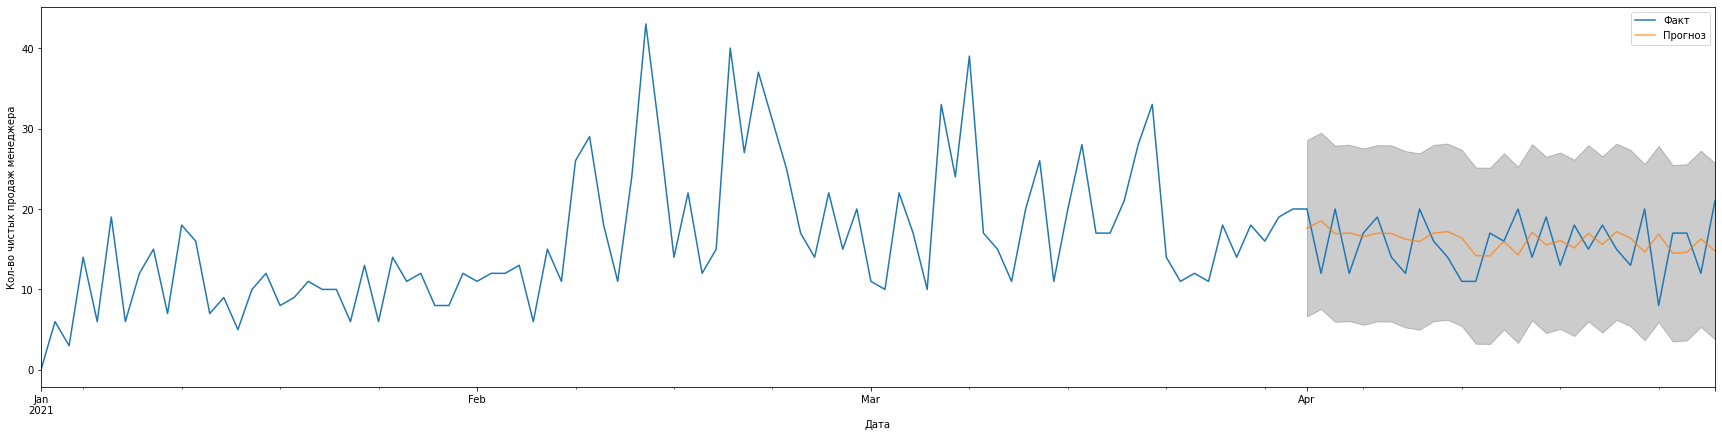

In [15]:
# спрогнозируем часть тренировочной выборки
pred = results_12.get_prediction(start=pd.to_datetime('2021-04-01'), dynamic=False)

# положим доверительный интервал отдельно
pred_ci = pred.conf_int()

# возьмем реальные значения тренировочной выборки, начиная с начала 2021 года и отобразим их на графике
ax = one_train['2021':].plot(label='Факт')

# отобразим на графике прогнозные значения
pred.predicted_mean.plot(ax=ax, label='Прогноз', alpha=.7, figsize=(30, 7))

# отобразим на графике доверительный интервал
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

# зададим название осей и включим отображение легенды 
ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во чистых продаж менеджера')
plt.legend()
plt.show()








Теперь можем посчитать показатели точности прогноза

In [16]:
mae = mean_absolute_error(one_train[-30:], pred.predicted_mean)
rmse = mean_squared_error(one_train[-30:], pred.predicted_mean)**0.5
true_month = one_train[-30:].sum()
pred_month =  pred.predicted_mean.sum()

print(f'mae:{mae}')
print(f'rmse:{rmse}')
print(f'реальное число продаж за месяц: {true_month}')
print(f'прогнозное число продаж за месяц: {round(pred_month,0)}')
print('SARIMA{}x{}'.format(best_param,best_param_seasonal))

mae:3.471581503370595
rmse:3.930310935238378
реальное число продаж за месяц: 471.0
прогнозное число продаж за месяц: 484.0
SARIMA(1, 1, 1)x(0, 1, 1, 12)


In [17]:
def mse_for_point(row):
    error = row['error']
    pred = row['predicted_mean']
    return (error**2)/(pred**2)
ratio = pred.predicted_mean.to_frame().join(one_train[-30:])

ratio['error'] = ratio['магазин 2']-ratio.predicted_mean
ratio['mse'] = ratio.apply(mse_for_point, axis=1)
print(f'точность прогноза {(1 - ratio.mse.mean())*100}')

точность прогноза 93.99191851124135


**Вывод 1:**
Как видно, при SARIMA модели с годовым циклом сезонности (m=12) наша модель хорошо предсказывает количество продаж в общем за месяц и не очень хорошо количество продаж по дням. Хотя в целом, точность по месяцу достаточно высокая: 93%.

Вспомним, что у нас есть не только годовой цикл сезонности (12 месяцев), но и недельный. Попробуем использовать его, т.е. возьмем m=52.

In [18]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]

print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 52)
SARIMAX: (0, 0, 1) x (0, 1, 0, 52)


In [19]:
list_param = []
list_param_seasonal = []
list_aic = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results_52 = mod.fit()
            print('SARIMA{}x{} - AIC:{}'.format(param,param_seasonal, results_52.aic))
            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_aic.append(results_52.aic)
        except: 
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 52) - AIC:6688.664939282296
SARIMA(0, 0, 0)x(0, 0, 1, 52) - AIC:6029.47799841792
SARIMA(0, 0, 0)x(0, 1, 0, 52) - AIC:5793.039077786396
SARIMA(0, 0, 0)x(0, 1, 1, 52) - AIC:5123.401492602579
SARIMA(0, 0, 0)x(1, 0, 0, 52) - AIC:5725.965301337355
SARIMA(0, 0, 0)x(1, 0, 1, 52) - AIC:5369.042996058076
SARIMA(0, 0, 0)x(1, 1, 0, 52) - AIC:5259.669954752297
SARIMA(0, 0, 0)x(1, 1, 1, 52) - AIC:5133.891898502141
SARIMA(0, 0, 1)x(0, 0, 0, 52) - AIC:6194.843082568515
SARIMA(0, 0, 1)x(0, 0, 1, 52) - AIC:5724.627888417872
SARIMA(0, 0, 1)x(0, 1, 0, 52) - AIC:5693.30064710373
SARIMA(0, 0, 1)x(0, 1, 1, 52) - AIC:4984.343673741651
SARIMA(0, 0, 1)x(1, 0, 0, 52) - AIC:5582.574766853161
SARIMA(0, 0, 1)x(1, 0, 1, 52) - AIC:5261.9725663593945
SARIMA(0, 0, 1)x(1, 1, 0, 52) - AIC:5129.404971270917
SARIMA(0, 0, 1)x(1, 1, 1, 52) - AIC:4994.649188332928
SARIMA(0, 1, 0)x(0, 0, 0, 52) - AIC:5671.335915180241
SARIMA(0, 1, 0)x(0, 0, 1, 52) - AIC:5355.664810711829
SARIMA(0, 1, 0)x(0, 1, 0, 52)

C:\Users\Baturin.GG\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(1, 0, 1)x(1, 0, 0, 52) - AIC:5035.406224788748
SARIMA(1, 0, 1)x(1, 0, 1, 52) - AIC:5031.738991862293
SARIMA(1, 0, 1)x(1, 1, 0, 52) - AIC:4968.706580323529
SARIMA(1, 0, 1)x(1, 1, 1, 52) - AIC:4784.696147359481
SARIMA(1, 1, 0)x(0, 0, 0, 52) - AIC:5490.406281418173
SARIMA(1, 1, 0)x(0, 0, 1, 52) - AIC:5184.70489980372
SARIMA(1, 1, 0)x(0, 1, 0, 52) - AIC:5742.778634916626
SARIMA(1, 1, 0)x(0, 1, 1, 52) - AIC:4933.5385455325995
SARIMA(1, 1, 0)x(1, 0, 0, 52) - AIC:5184.5071693519585
SARIMA(1, 1, 0)x(1, 0, 1, 52) - AIC:5186.175925797777
SARIMA(1, 1, 0)x(1, 1, 0, 52) - AIC:5114.062062322864
SARIMA(1, 1, 0)x(1, 1, 1, 52) - AIC:4960.722997198792
SARIMA(1, 1, 1)x(0, 0, 0, 52) - AIC:5311.086475351999
SARIMA(1, 1, 1)x(0, 0, 1, 52) - AIC:5017.375650812116
SARIMA(1, 1, 1)x(0, 1, 0, 52) - AIC:5580.620737101061
SARIMA(1, 1, 1)x(0, 1, 1, 52) - AIC:4773.480168044067
SARIMA(1, 1, 1)x(1, 0, 0, 52) - AIC:5022.484922308227
SARIMA(1, 1, 1)x(1, 0, 1, 52) - AIC:5018.885750417707
SARIMA(1, 1, 1)x(1, 1, 0, 5

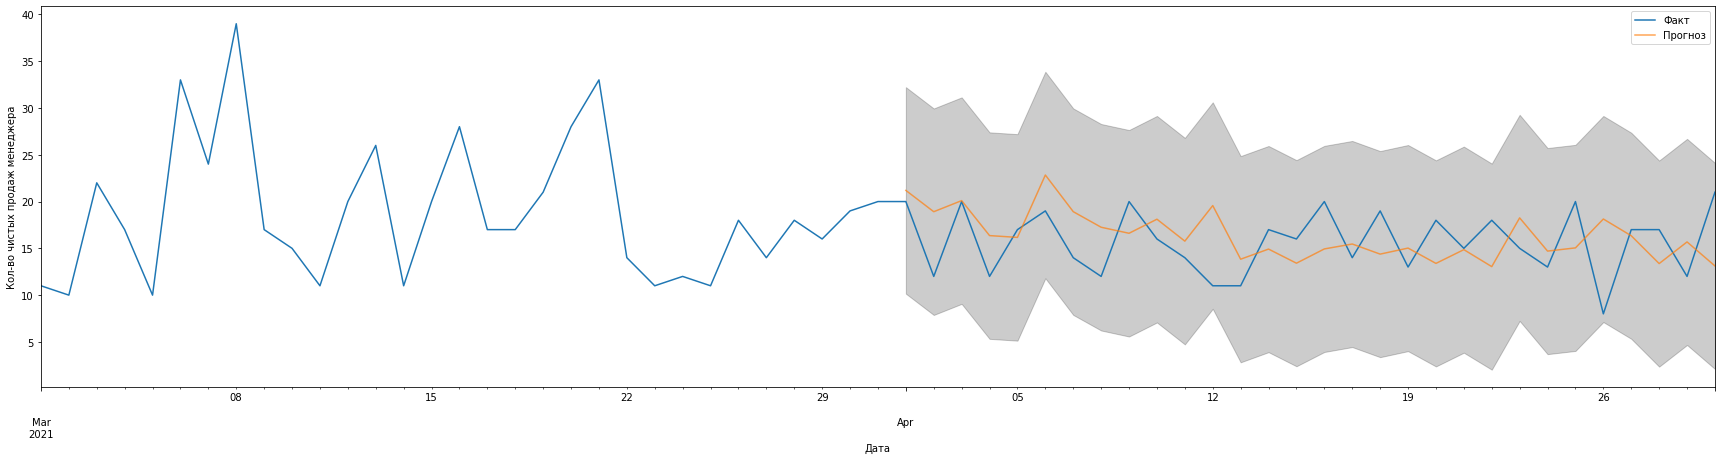

mae:3.6507882859300103
rmse:4.382067049370141
реальное число продаж за месяц: 471.0
прогнозное число продаж за месяц: 490.0
SARIMA(1, 1, 1)x(0, 1, 1, 52)


In [20]:


# найдем индекс минимального значения критерия aic
best_aic, idx_of_best_aic = min((val, idx) for (idx, val) in enumerate(list_aic))

# найдем (p,d,q) при которых достигается минимальное значение aic
best_param = list_param[idx_of_best_aic]

# найдем (P,D,Q) при которых достигается минимальное значение aic
best_param_seasonal = list_param_seasonal[idx_of_best_aic]

mod = sm.tsa.statespace.SARIMAX(one_train,
                                order=(best_param[0], best_param[1], best_param[2]),
                                seasonal_order=(best_param_seasonal[0], best_param_seasonal[1], best_param_seasonal[2], best_param_seasonal[3]),
                                enforce_stationarity=True,
                                enforce_invertibility=True
                                )
results_52 = mod.fit()



# спрогнозируем часть тренировочной выборки
pred = results_52.get_prediction(start=pd.to_datetime('2021-04-01'), dynamic=False)

# положим доверительный интервал отдельно
pred_ci = pred.conf_int()

# возьмем реальные значения тренировочной выборки, начиная с начала марта 2021 года и отобразим их на графике
ax = one_train['2021-03-01':].plot(label='Факт')

# отобразим на графике прогнозные значения
pred.predicted_mean.plot(ax=ax, label='Прогноз', alpha=.7, figsize=(30, 7))

# отобразим на графике доверительный интервал
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

# зададим название осей и включим отображение легенды 
ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во чистых продаж менеджера')
plt.legend()
plt.show()


mae = mean_absolute_error(one_train[-30:], pred.predicted_mean)
rmse = mean_squared_error(one_train[-30:], pred.predicted_mean)**0.5
true_month = one_train[-30:].sum()
pred_month =  pred.predicted_mean.sum()

print(f'mae:{mae}')
print(f'rmse:{rmse}')
print(f'реальное число продаж за месяц: {true_month}')
print(f'прогнозное число продаж за месяц: {round(pred_month,0)}')
print('SARIMA{}x{}'.format(best_param,best_param_seasonal))

In [21]:
ratio = pred.predicted_mean.to_frame().join(one_train[-30:])

ratio['error'] = ratio['магазин 2']-ratio.predicted_mean
ratio['mse'] = ratio.apply(mse_for_point, axis=1)
print(f'точность прогноза {(1 - ratio.mse.mean())*100}')

точность прогноза 92.59294556567545


**Вывод 2:** при использовании недельного цикла сезонности наша модель, на графике выглядит лучше, но mae, rmse и оценка точности говорят нам, что модель хуже. Она больше ошибает в подневном прогнозе и как следствие, сумма результатов подневного прогноза находится даль о суммы результатов фактических данных.

**Вывод 3:** рабочей машины не хвататет чтобы подобрать оптимальные параметры модели и произвести расчет на тестовой выборке, для модели с дневным циклом сезонности (т.е m = 365.25)

Проверим, а на сколько точно прогнозирует лучшая (из найденных нами) модель с параметрами (p=1, d=1, q=1)(P=0, D=1, Q=1, m=12) закрытую часть выборки.

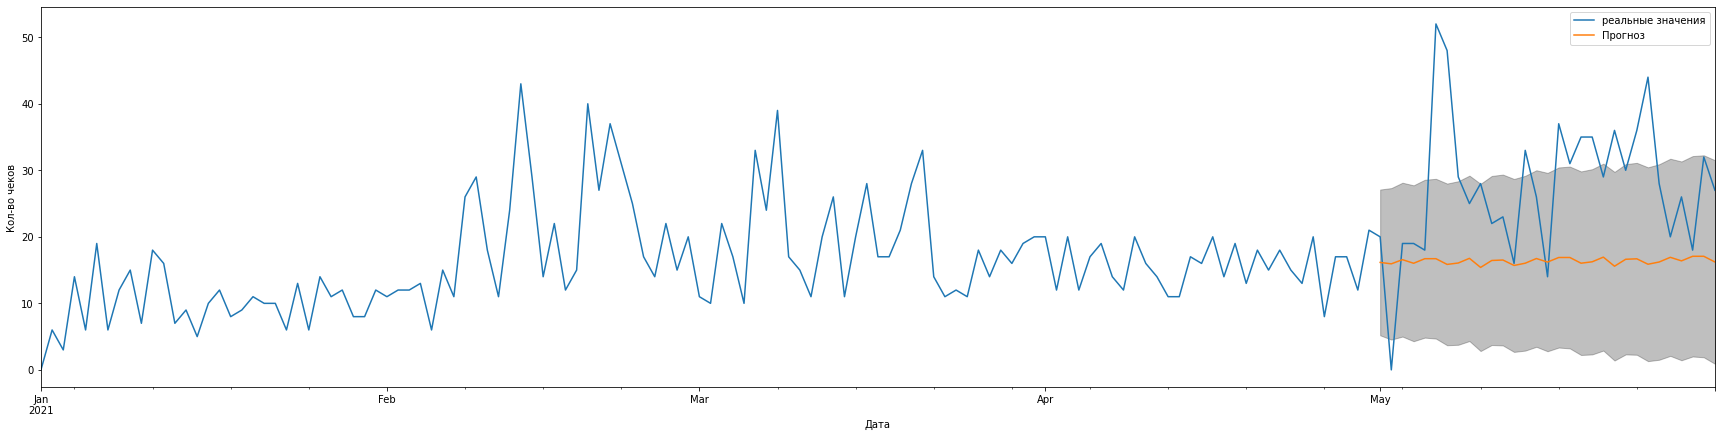

In [34]:
# обучим модель на тренировочной выборке
mod = sm.tsa.statespace.SARIMAX(one_train,
                                order=(1,1,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=True,
                                enforce_invertibility=True
                                )
results = mod.fit()


# спрогнозируем валидационную выборку
pred_uc = results.get_forecast(steps=one_valid.shape[0])

# положим доверительный интервал отдельно
pred_ci = pred_uc.conf_int()

# возьмем реальные значения, начиная с начала 2021 года и отобразим их на графике
ax = one['2021-01-01':].plot(label='реальные значения', figsize=(30, 7))

# отобразим на графике прогнозные значения
pred_uc.predicted_mean.plot(ax=ax, label='Прогноз')

# отобразим на графике доверительный интервал
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
                
# зададим название осей и включим отображение легенды                
ax.set_xlabel('Дата')
ax.set_ylabel('Кол-во чеков')
plt.legend()
plt.show()


In [32]:
ratio = pred_uc.predicted_mean.to_frame().join(one_valid)

ratio['error'] = ratio['магазин 2']-ratio.predicted_mean
ratio['mse'] = ratio.apply(mse_for_point, axis=1)
ratio.mse.mean()
print(f'точность прогноза {(1 - ratio.mse.mean())*100}')

точность прогноза 12.044715733966981


# Вывод:
На представленных исходных данных, простыми способами, без использования дополнительных признаков (например номер месяца, номер дня в году, номер дня в месяце, номер дня в недели) достаточно сложно получить точную SARIMA модель, которая будет с достаточной степенью точности предсказывать будущее. Даже лучшая, из полученных нами, модель SARIMA с параметрами (p=1, d=1, q=1)(P=0, D=1, Q=1, m=12), которая дает 94% точности на тренировочных данных - дала всего 12% точности на закрытой части выборки.
